# Section 5 - Canny FRCNN

In this section, we utilize the OpenCV implementation of the Canny algorithm as a preprocessing layer to Faster-RCNN and analyze its performance.  Canny is a popular multi-stage edge detection algorithm designed to a) highlight the edges of all objects within an image and b) remove anything between different edges. 

In using this algorithm, we hypothesize that FRCNN will achieve better performance on more complex images since much of the noise of non-targets is removed and only the outline of the edges is considered.  By training on a ship's outline, which is relatively consistent regardless of ship sizes, we expect the model to identify targets in areas that previously had significant amounts of noise, such as docks, inclement weather, and other confusers.

## 5.1 - Canny Overview

The Canny pipeline includes three steps:

1. **Noise Reduction**: Use Gaussian Blurring on the entire image to reduce noise surrounding edges that may lead to false positives.
2. **Gradient Intensity**: It then uses the Sobel kernel (another Edge Detection method) in the X and Y directions to determine the gradient magnitude. Then it uses a formula to extract the gradient direction of individual pixels.
3. **Non-Maximum Suppression**: Once edges are proposed, NMS is used to remove any pixels that may be a false positive edge.

For more details on the Canny algorithm, OpenCV's documentation has a good explanation of the topic: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

In [1]:
# Utility Imports
import os, sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cv2

project_path = pathlib.Path.cwd().parent.resolve().parent.resolve()
print(f"Project path: {project_path}")

sys.path.append(os.path.join(project_path, "src", "frcnn"))
sys.path.append(os.path.join(project_path, "src", "utils"))

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Model and Model Utility Imports
import torchvision
import torch
from frcnn_models import CannyFRCNN



Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


## 5.2 - Data Analysis

Below, we provide an example of how Canny can assist the detection models by remove noise and highlight ship outlines.  In the original image, targets are intermingled with what appears to be either inclement weather or some other noise type.  In the succeeding subplot, we can see those inclement weather spots are fully removed while the outline of the targets are retained.

In [ ]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0, std=1),
    torchvision.transforms.Grayscale(1)
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


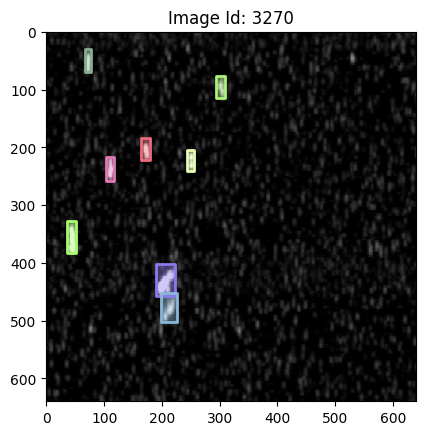

In [4]:
image, target = train_data._get_image(3270, True, True)

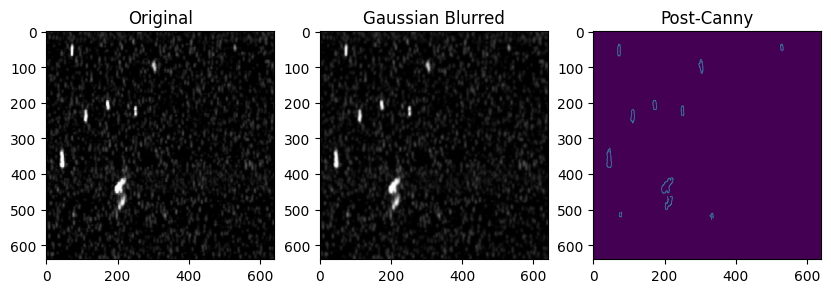

In [5]:
gaussian_image = cv2.GaussianBlur(np.array(image), ksize=(5, 5), sigmaX=2.0)
canny_image = cv2.Canny(gaussian_image, 200, 100)
train_data.show_edited_subplot([image, gaussian_image, canny_image], ["Original", "Gaussian Blurred", "Post-Canny"], "", "")

### 5.2.1 - False Positives

As shown in 5.3, setting the Canny thresholds to (200, 100) began yield positive results like the image above.  However, there are some drawbacks to using static threshold values. Setting the threshold too high can remove key target details or even entire targets. Using a value too small will not remove enough noise and can reduce model performance.  As we see in the below figures, (200, 100) is not a high enough threshold to clear much of the noise from the shoreline, inevitably leading to misclassifications.

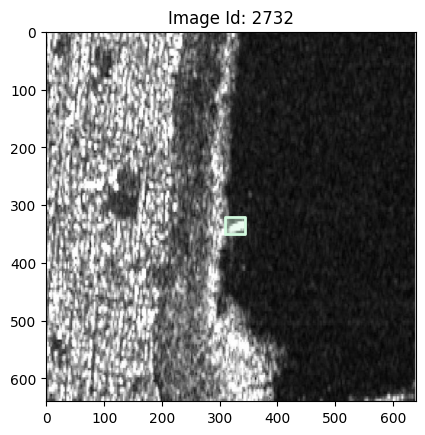

In [6]:
image, target = train_data._get_image(2732, get_image=True)

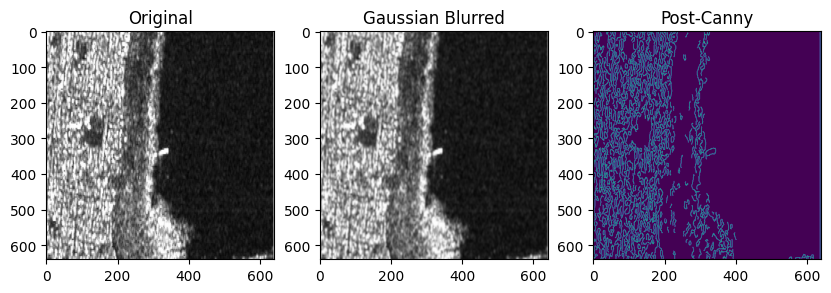

In [7]:
gaussian_image = cv2.GaussianBlur(np.array(image), ksize=(5, 5), sigmaX=2.0)
canny_image = cv2.Canny(gaussian_image, 200, 100)
train_data.show_edited_subplot([image, gaussian_image, canny_image], ["Original", "Gaussian Blurred", "Post-Canny"], "", "")

## Section 5.3 Model Construction and Training

In this section, we build the CannyFRCNN model.  We use a 3x3 kernel and standard deviation of 1 for Gaussian Blurring. For Canny, using 200 or higher for threshold 1 and 100 or higher for threshold 2 began to show good results on most images as this is when noise began being filtered out. 

In [8]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=train_data._packager)

In [9]:
# Build the baseline model
frcnn_adam = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
input_features = frcnn_adam.roi_heads.box_predictor.cls_score.in_features
frcnn_adam.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn_adam.parameters(), lr=1e-8)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "valid")
validation_data = SeaSarFRCNN(validation_images, validation_annotations, transform=tester_transforms)
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=True, collate_fn=validation_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [11]:
canny_adam = CannyFRCNN(frcnn_adam, 'cuda', (3, 3), 1.0, 200, 100)
worker_adam = ModelWorkerFRCNN(optimizer, canny_adam, False)

In [12]:
worker_adam.train(train_dataloader, num_epochs=10, indices_to_skip=[3736])

Batch: 4715/4716 | Batch Loss: 0.66473525762557983

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 8245.770513564348
Loss Objectness: 5025.825944202021
RPN Region Proposal Losses: 379.1500577130064
Classifier Loss: 2792.71569827199
Bounding Box Region Loss: 48.078811162151396


Batch: 4715/4716 | Batch Loss: 1.39379048347473143

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 5749.2450467944145
Loss Objectness: 4206.530095352791
RPN Region Proposal Losses: 369.57988930604915
Classifier Loss: 1125.1480242908
Bounding Box Region Loss: 47.987029462703504


Batch: 4715/4716 | Batch Loss: 0.86203306913375855

############# Epoch: 2 Complete #############
Total Epoch Combined Loss: 4326.746557541192
Loss Objectness: 3443.5467109307647
RPN Region Proposal Losses: 363.45839480565337
Classifier Loss: 479.09021021053195
Bounding Box Region Loss: 40.651243549073115


Batch: 4715/4716 | Batch Loss: 0.10020644217729568

############# Epoch: 3 Compl

In [14]:
# Run validation
worker_adam.validation(validation_dataloader, 10, [])

Batch: 1345/1346 | Batch Loss: 0.22751539945602417

############# Epoch: 0 Complete #############
	Total Epoch Loss: 500.3855895996094
	Loss Objectness: [364.90880823880434]
	RPN Region Proposal Losses: 88.77278960848344
	Classifier Loss: 45.17289817985147
	Bounding Box Region Loss: 1.531112742014443
Batch: 1345/1346 | Batch Loss: 0.12850290536880493

############# Epoch: 1 Complete #############
	Total Epoch Loss: 500.1402587890625
	Loss Objectness: [364.90880823880434, 364.82368052750826]
	RPN Region Proposal Losses: 88.59846901500714
	Classifier Loss: 45.187084985896945
	Bounding Box Region Loss: 1.531112742014443
Batch: 1345/1346 | Batch Loss: 0.16246338188648224

############# Epoch: 2 Complete #############
	Total Epoch Loss: 500.84014892578125
	Loss Objectness: [364.90880823880434, 364.82368052750826, 365.34771905094385]
	RPN Region Proposal Losses: 88.78139327073586
	Classifier Loss: 45.17953258194029
	Bounding Box Region Loss: 1.531112742014443
Batch: 1345/1346 | Batch Loss: 0

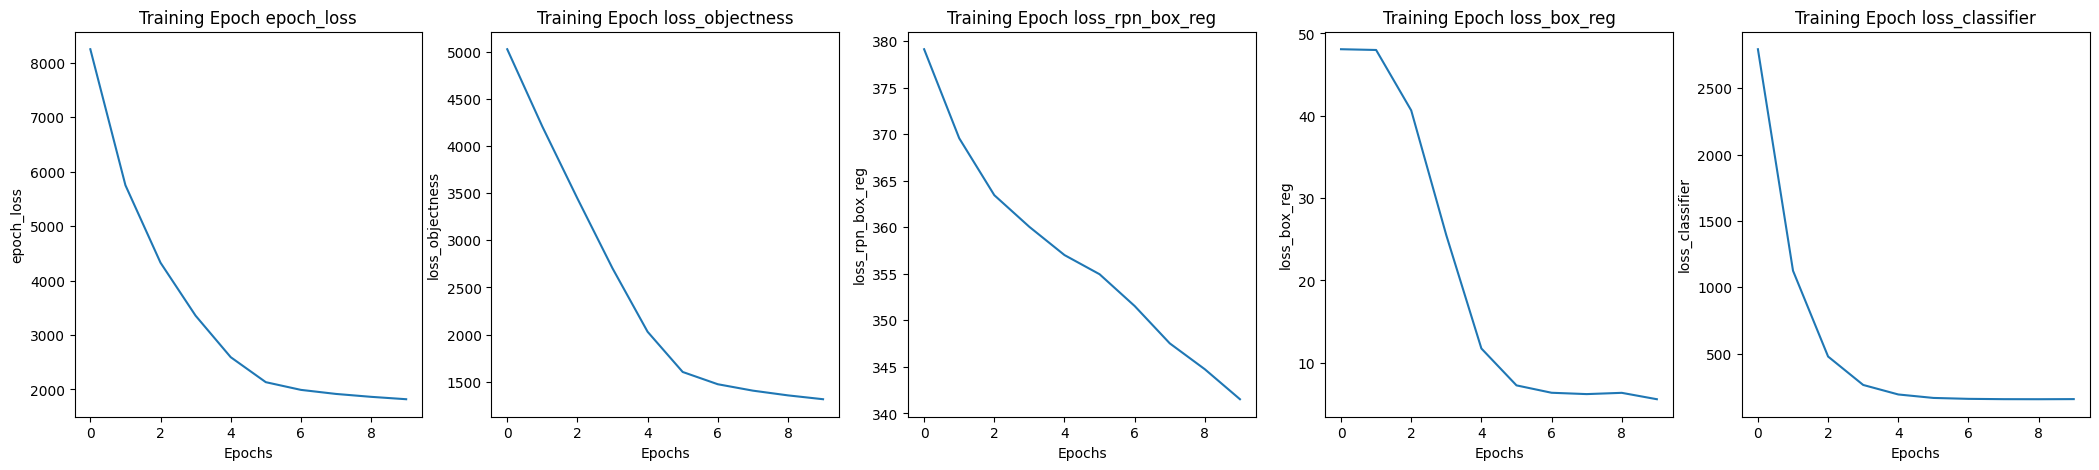

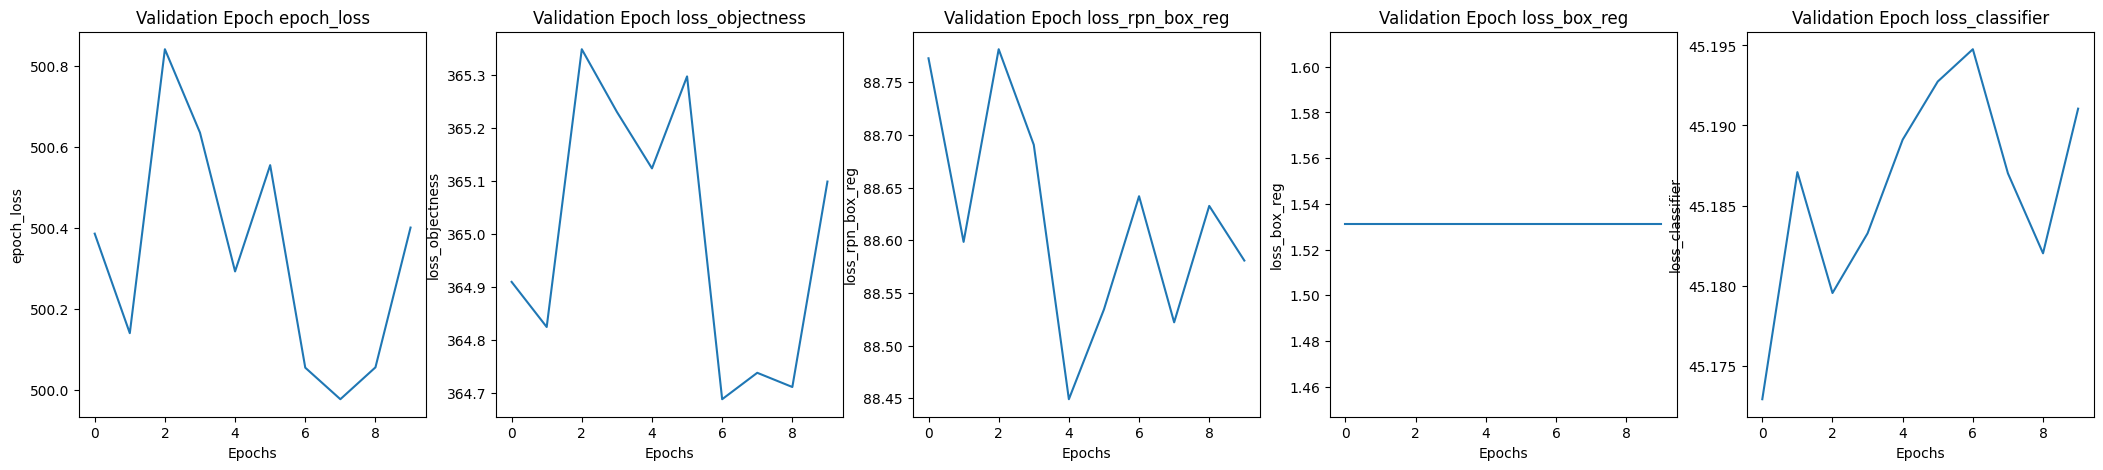

In [15]:
# Plot Baseline training and validation metrics
worker_adam.plot_losses(True)
plt.show()
worker_adam.plot_losses(False)
plt.show()

In [20]:
# Build the baseline model
frcnn_sgd = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
input_features_sgd = frcnn_sgd.roi_heads.box_predictor.cls_score.in_features
frcnn_sgd.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features_sgd, 2)

# Build the loss function and optimizer
sgd = torch.optim.SGD(frcnn_sgd.parameters(), momentum=0.9, lr=1e-5)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
canny_sgd = CannyFRCNN(frcnn_sgd, 'cuda', (3, 3), 1.0, 200, 100)

In [22]:
sgdWorker = ModelWorkerFRCNN(optimizer=sgd, frcnn=canny_sgd, quiet=False)

In [23]:
sgdWorker.train(train_dataloader, 10, [3736])

Batch: 4715/4716 | Batch Loss: 0.22071596980094917

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 1961.0956173166633
Loss Objectness: 1366.2906138673425
RPN Region Proposal Losses: 337.416179045802
Classifier Loss: 234.19606402353384
Bounding Box Region Loss: 23.192758860886325


Batch: 4715/4716 | Batch Loss: 0.19637836515903473

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 1581.6192066892982
Loss Objectness: 1163.7600337266922
RPN Region Proposal Losses: 320.91386938521464
Classifier Loss: 80.14356391713955
Bounding Box Region Loss: 16.801739876470837


Batch: 4715/4716 | Batch Loss: 0.13248559832572937

############# Epoch: 2 Complete #############
Total Epoch Combined Loss: 1569.1473912969232
Loss Objectness: 1159.3545767888427
RPN Region Proposal Losses: 319.4764182272229
Classifier Loss: 74.19228923413903
Bounding Box Region Loss: 16.124107455666504


Batch: 4715/4716 | Batch Loss: 0.37354573607444763

############# Epoch: 3 

In [24]:
sgdWorker.validation(validation_dataloader, 10, [])

Batch: 1345/1346 | Batch Loss: 0.17496885359287262

############# Epoch: 0 Complete #############
	Total Epoch Loss: 426.23858642578125
	Loss Objectness: [321.7717659547925]
	RPN Region Proposal Losses: 82.33001902778051
	Classifier Loss: 18.339707791805267
	Bounding Box Region Loss: 3.7971730733964932
Batch: 1345/1346 | Batch Loss: 0.10023176670074463

############# Epoch: 1 Complete #############
	Total Epoch Loss: 425.51019287109375
	Loss Objectness: [321.7717659547925, 321.5789496079087]
	RPN Region Proposal Losses: 82.02002424080274
	Classifier Loss: 18.114256530767307
	Bounding Box Region Loss: 3.7971730733964932
Batch: 1345/1346 | Batch Loss: 0.23427325487136846

############# Epoch: 2 Complete #############
	Total Epoch Loss: 426.2251281738281
	Loss Objectness: [321.7717659547925, 321.5789496079087, 321.7153098285198]
	RPN Region Proposal Losses: 82.20287242610357
	Classifier Loss: 18.50968262925744
	Bounding Box Region Loss: 3.7971730733964932
Batch: 1345/1346 | Batch Loss: 0.

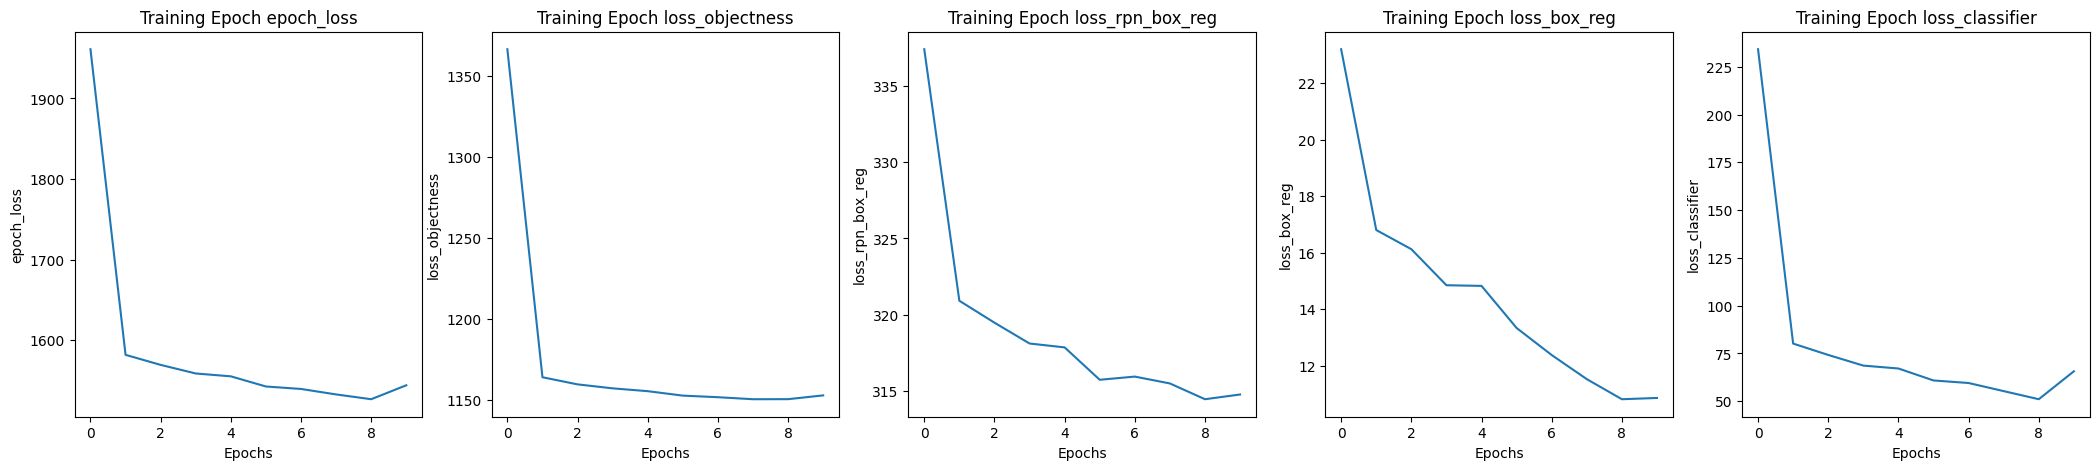

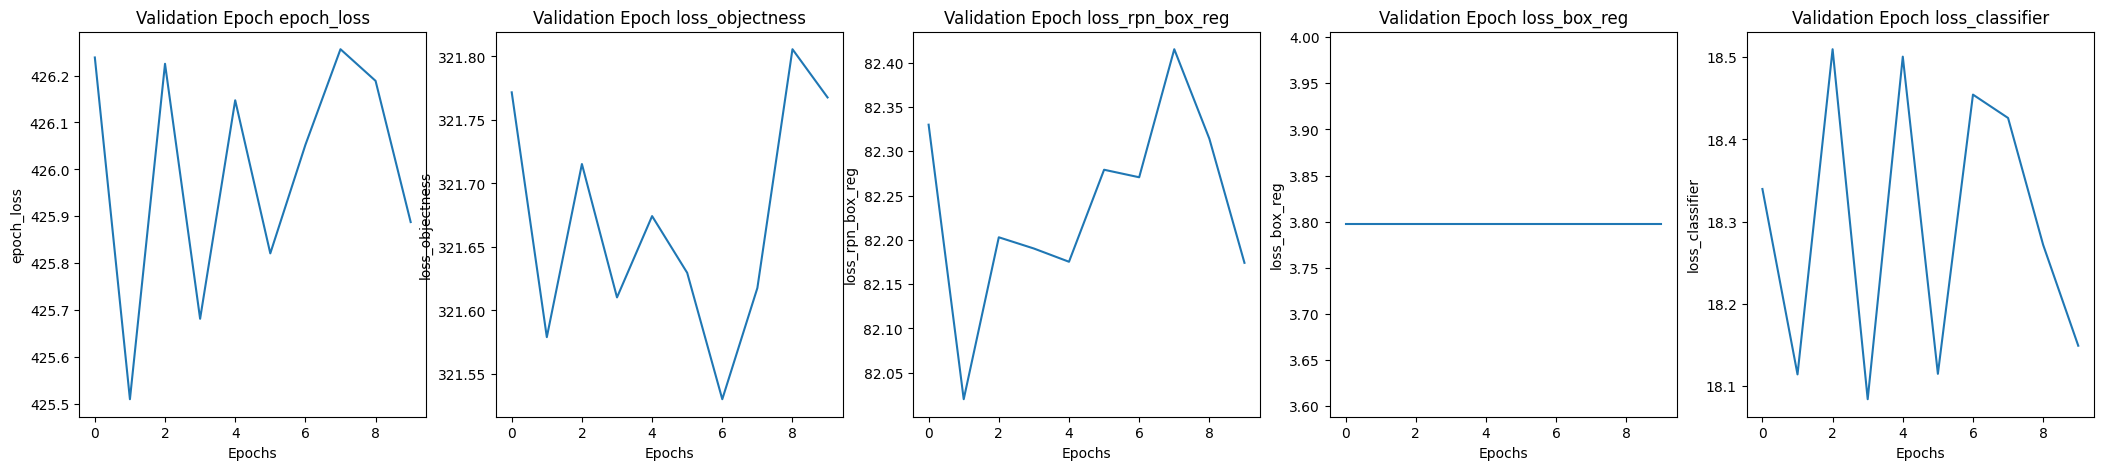

In [25]:
# Plot Baseline training and validation metrics
sgdWorker.plot_losses(True)
plt.show()
sgdWorker.plot_losses(False)
plt.show()

## Test

In [26]:
test_images = os.path.join(workspace_builder._data_path, "test")
test_annotations = os.path.join(workspace_builder._data_path, "annotations", "test_annotations.coco.json")
test_data = SeaSarFRCNN(test_images, test_annotations, transform=tester_transforms)
test_data = torchvision.datasets.wrap_dataset_for_transforms_v2(test_data, target_keys=("boxes", "labels"))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=test_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
from torchmetrics.functional.detection import intersection_over_union
from torchmetrics.detection import MeanAveragePrecision

# Moved model_test function from ModelWorker to here due to issue where FRCNN makes no predictions
# regardless of threshold when this function is called form outside the notebook.
def model_test(frcnn, device, test_data: torch.utils.data.DataLoader, threshold: float = 0.8):
    """
    Run Testing on the given model for this worker.

    Args:
        - test_data: Loader object for all testing data.
        - threshold: Minimum IOU score to consider in our metric calculations.
    """
    performance = {"Image": [], "Ground Truth": [], "Prediction": []}

    maP = MeanAveragePrecision()
    # Set the model to evaluation mode
    frcnn.eval()
    with torch.no_grad():
        for test_batch, (images, annotations) in enumerate(test_data):
            images = tuple([image.to(device) for image in images])
            annotations = [{key: value.to(device) for key, value in target.items()} for target in annotations]

            test_prediction = frcnn(images, annotations) # Make a prediction on the current image.

            # Canny and Robinson Compass output a tuple of wrapper of test_predictions, throwing error. Fix it
            if isinstance(test_prediction, tuple):
                test_prediction = test_prediction[0]

            maP.update(test_prediction, annotations)
            test_boxes = test_prediction[0]['boxes'].cpu().detach()

            ground_truth = []
            # Find the Intersection over Union for each bounding box compared to the ground truth annotation
            for gt in annotations[0]['boxes']:
                ground_truth.append(torch.unsqueeze(gt.cpu().detach(), 0)[0])

            ground_truth = torch.stack(ground_truth)

            performance["Ground Truth"].append(ground_truth)
            performance["Prediction"].append(test_boxes)
            performance["Image"].append([image.cpu().detach() for image in images])

            print(f"Test Batch: {test_batch}\r", end="")

    return performance, maP

In [85]:
threshold = 0.2

In [97]:
performance, maP = model_test(frcnn_adam, 'cuda', test_dataloader, None)

In [98]:
performance = worker_adam.get_test_metrics(performance, threshold)

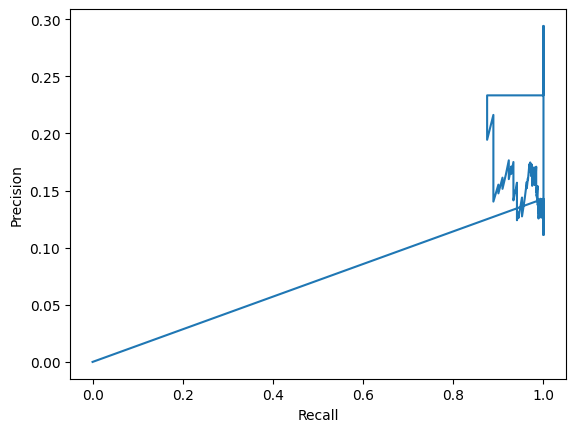

In [99]:
worker_adam.plot_PR_curve(performance)
plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MeanAveragePrecision'>)

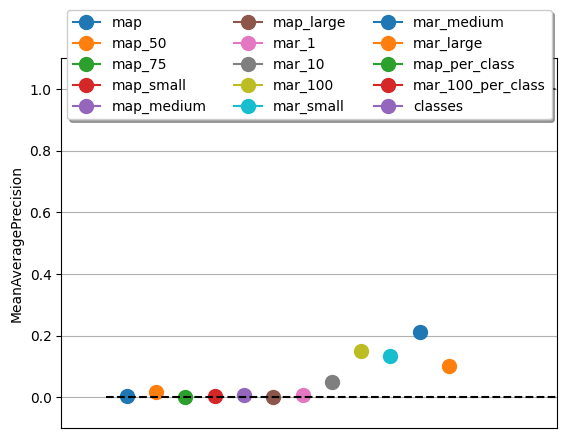

In [100]:
# Plot Mean Average Precision
maP.compute()
maP.plot()

In [90]:
# Compare with Stochastic Gradient Descent optimizer.
threshold = 0.2
performance, maP = model_test(frcnn_sgd, 'cuda', test_dataloader, threshold)

In [91]:
performance = sgdWorker.get_test_metrics(performance, threshold)

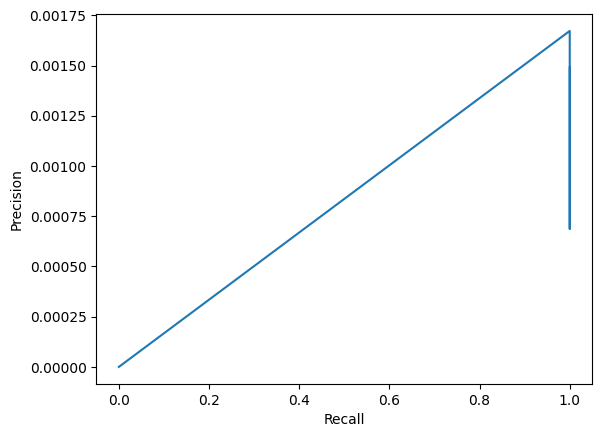

In [92]:
sgdWorker.plot_PR_curve(performance)
plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MeanAveragePrecision'>)

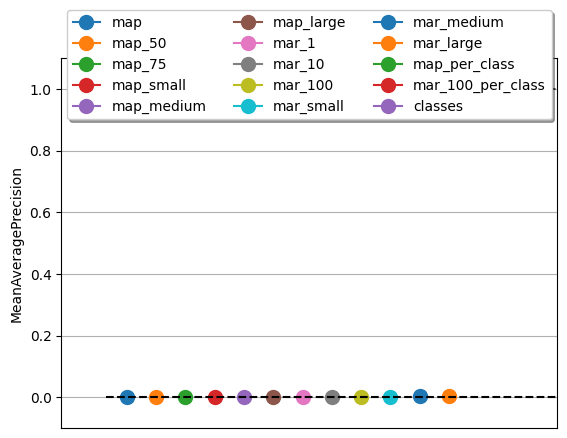

In [93]:
# Plot Mean Average Precision
maP.compute()
maP.plot()